In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score
from datetime import date
import matplotlib.pyplot as plt
import mysql.connector


features=['draw','addedWeight','declaredHorseWeight','horse_winPer',
                 'horse_winCount','jockey_winPer','jockey_winCount','horse_newDistance','horse_newHorse',
         'horse_last4SpeedRate','horse_latestSpeedRate','Days_from_lastRace']
target=['finishTime']
file0 = "/Users/apple/Workspace/intelliJ/jockey/regression_20190127.csv"

dataset0 = pd.read_csv(file0)

20190123
2200 5


/Users/apple/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


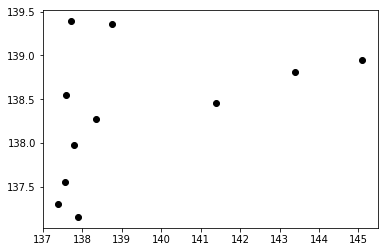

Mean squared error: 6.54
Variance score: 0.00
1000 4


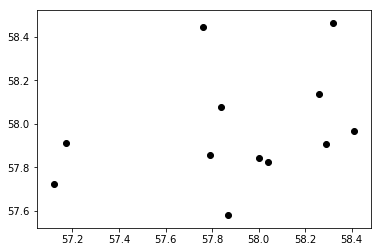

Mean squared error: 0.16
Variance score: -0.03
1650 5


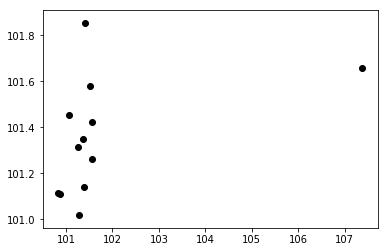

Mean squared error: 2.78
Variance score: 0.04
1200 4


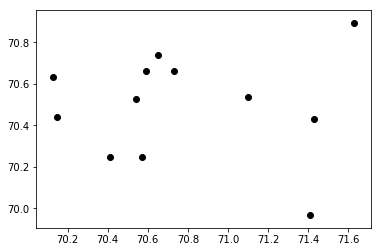

Mean squared error: 0.37
Variance score: -0.61
1650 4


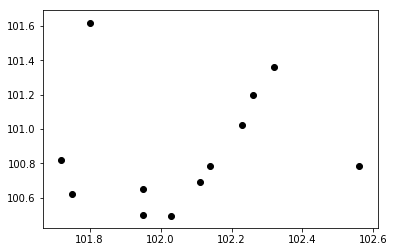

Mean squared error: 1.56
Variance score: -25.85
1200 3


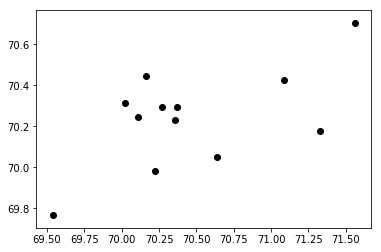

Mean squared error: 0.26
Variance score: 0.16
1800 3


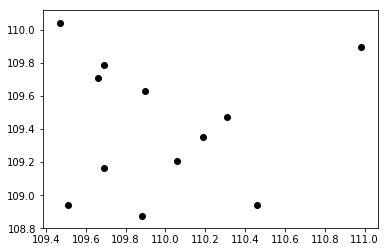

Mean squared error: 0.64
Variance score: -2.55
1650 3


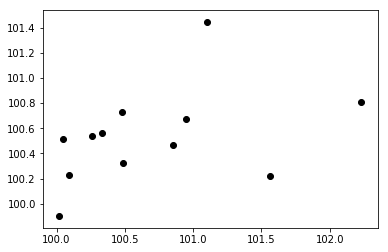

Mean squared error: 0.38
Variance score: 0.08


In [3]:
allDates = [20190123] #dataset0.rateDate.unique()
allDates.sort()
for raceDate in allDates:
    #if(raceDate <20180218):
    #     continue
    print(raceDate)
    dataset_ofADay = dataset0[(dataset0['rateDate']==raceDate)]
    allSeqs = dataset_ofADay.raceSeqOfDate.unique()
    for seq in allSeqs:
        dataset_test =  dataset_ofADay[(dataset_ofADay['raceSeqOfDate']==seq)]
        distance = dataset_test['distance'].iloc[0]
        raceClass = dataset_test['raceClass'].iloc[0]
        print(raceDate,seq,distance,raceClass)
        
        dataset_train = dataset0[(dataset0['raceClass']==raceClass) & (dataset0['distance']==distance) 
                        & (dataset0['rateDate']!=raceDate)]
        #dataset_train.shape
        if(dataset_train.size==0):
            continue
        #regression model of lbw or finishTime
        X_train=dataset_train[features]
        y_train=dataset_train[target] #lbw

        X_test=dataset_test[features]
        y_test=dataset_test[target] #lbw


        reg = LinearRegression()
        reg.fit(X_train,y_train)
        y_test_predicted=reg.predict(X_test)
        
        plt.scatter(y_test, y_test_predicted,  color='black')
        plt.show()
        print("Mean squared error: %.2f"
              % mean_squared_error(y_test, y_test_predicted))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_test_predicted))

       


In [6]:
 #explained_variance_score(y_test, y_test_predicted)
df = pd.DataFrame(data=y_test_predicted, index=y_test.index,columns=['finishTime_predicted'])
dataset_test_toshow=dataset_test[['rateDate','raceSeqOfDate','distance','raceClass','horseId','place','winOdds','lbw','finishTime']]
dataset_test_withPredicted=dataset_test_toshow.merge(df,how='inner',left_index=True,right_index=True)
dataset_test_withPredicted = dataset_test_withPredicted.sort_values(['finishTime_predicted'])
dataset_test_withPredicted

,rateDate,raceSeqOfDate,distance,raceClass,horseId,place,winOdds,lbw,finishTime,finishTime_predicted
13558,20190123,8,1650,3,A228,1,3.2,0.00,100.02,99.901547
13568,20190123,8,1650,3,T098,11,86.0,9.50,101.56,100.224775
13560,20190123,8,1650,3,B085,3,4.1,0.50,100.09,100.232432
13564,20190123,8,1650,3,A189,7,37.0,3.00,100.49,100.323981
13565,20190123,8,1650,3,A362,8,21.0,5.25,100.85,100.467665
13559,20190123,8,1650,3,A240,2,4.3,0.15,100.05,100.511579
13561,20190123,8,1650,3,V379,4,42.0,1.50,100.26,100.535173
13562,20190123,8,1650,3,B223,5,5.6,2.00,100.33,100.564006
13566,20190123,8,1650,3,V279,9,20.0,5.75,100.95,100.673959
13563,20190123,8,1650,3,A247,6,15.0,2.75,100.48,100.728600
